In [5]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

Analysing previous shows gives us a prior belief that the true total price follows a normal distribution...

$$\text{truePrice} \sim \text{Normal}(\mu=35000.0,~\sigma=7500.0)$$

For the individual prizes we can assume a similar normal distribution for our belief of their prices...

$$\text{prizePrice}_i \sim \text{Normal}(\mu_i,~\sigma_i),\;\; i=1,2$$

The **true** price of our two prizes will be the sum of these plus some error, $\epsilon$...

$$\text{suiteTruePrice}=\text{prizePrice}_1+\text{prizePrice}_2+\epsilon$$

When we're shown our two prizes we can make a guess at their prices ($\mu_1, \mu_2$) and express our uncertainty in those prices ($\sigma_1, \sigma_2$). For example, ...

* A trip to Toronto ($\mu=12000,\sigma=3000$)
* A snowblower ($\mu=3000,\sigma=500$)

$$\text{toronto} \sim \text{Normal}(\mathit{mu}=12000.0,~\mathit{sigma}=3000.0)$$

$$\text{snowblower} \sim \text{Normal}(\mathit{mu}=3000.0,~\mathit{sigma}=500.0)$$

In [2]:
muTruePricePrior=35000
sigmaTruePricePrior=7500

prizePriceGuesses=[12000,3000]
prizePriceUncertainties=[3000,500]

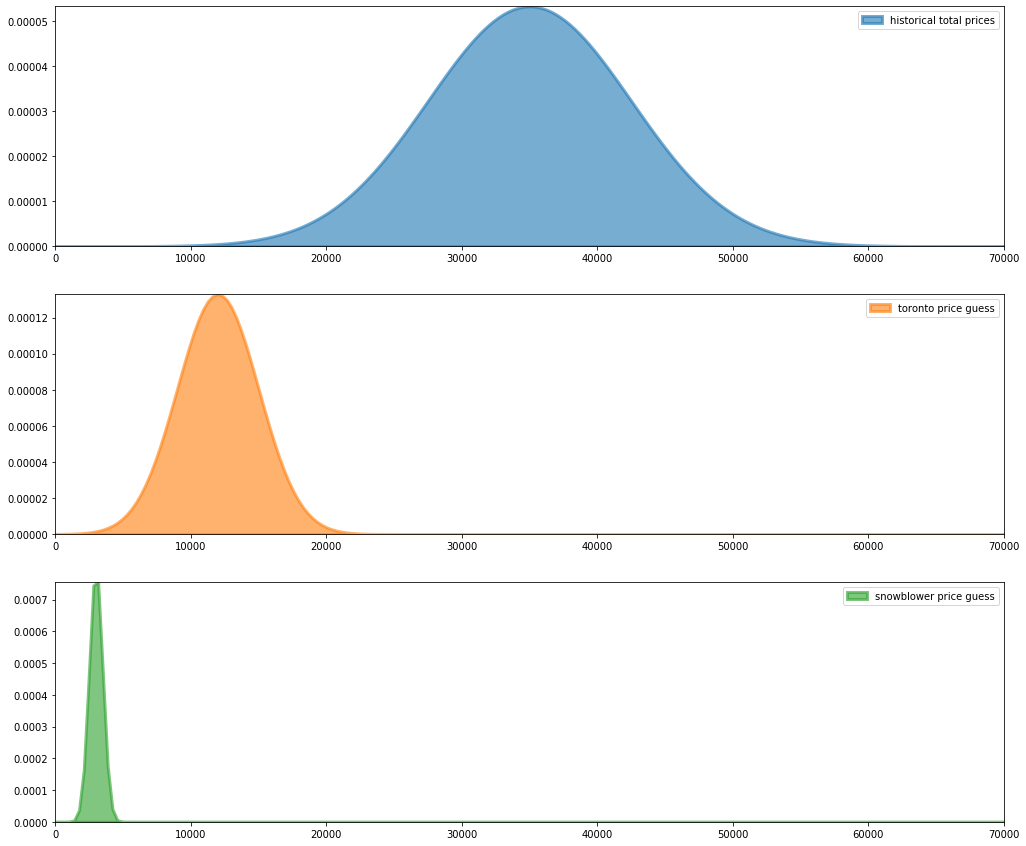

In [28]:
xs=np.linspace(0, 70000, 200)

plt.figure(figsize=(17,15))

plt.subplot(311)
plt.fill_between(xs, 0, stats.norm.pdf(xs, muTruePricePrior, sigmaTruePricePrior), label='historical total prices', color='C0', alpha=0.6, lw=3)
plt.legend()
plt.autoscale(tight=True)

plt.subplot(312)
plt.fill_between(xs, 0, stats.norm.pdf(xs, prizePriceGuesses[0], prizePriceUncertainties[0]), label='toronto price guess', color='C1', alpha=0.6, lw=3)
plt.legend()
plt.autoscale(tight=True)

plt.subplot(313)
plt.fill_between(xs, 0, stats.norm.pdf(xs, prizePriceGuesses[1], prizePriceUncertainties[1]), label='snowblower price guess', color='C2', alpha=0.6, lw=3)
plt.legend()
plt.autoscale(tight=True);

Now we can use PyMC3 to get an updated distribution (posterior) of the total price distribution having seen our prizes...

* Remember that random variables must be created within the context of a model, BUT we can get a *stateless* distribution using the `.dist` function. This allows for probabilities to be evaluated and random numbers to be drawn.
* Usually the likelihood is determined by defining a distribution and relating some real data (observations) to it. Because we don't have any observed data here we use the [`Potential`](http://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class) class to create a custom likelihood function.

In [32]:
with pm.Model() as model:
    truePrice=pm.Normal("truePrice", muTruePricePrior, sigmaTruePricePrior)
    toronto=pm.Normal("toronto", prizePriceGuesses[0], prizePriceUncertainties[0])
    snowblower=pm.Normal("snowblower", prizePriceGuesses[1], prizePriceUncertainties[1])
    estimate=toronto+snowblower
    
    logp=pm.Normal.dist(mu=estimate, sd=3e3).logp(truePrice)
    error = pm.Potential("error", logp)
    
    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]

price_trace = burned_trace["truePrice"]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [snowblower]
>Metropolis: [toronto]
>Metropolis: [truePrice]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████| 202000/202000 [01:31<00:00, 2204.13draws/s]
The number of effective samples is smaller than 10% for some parameters.


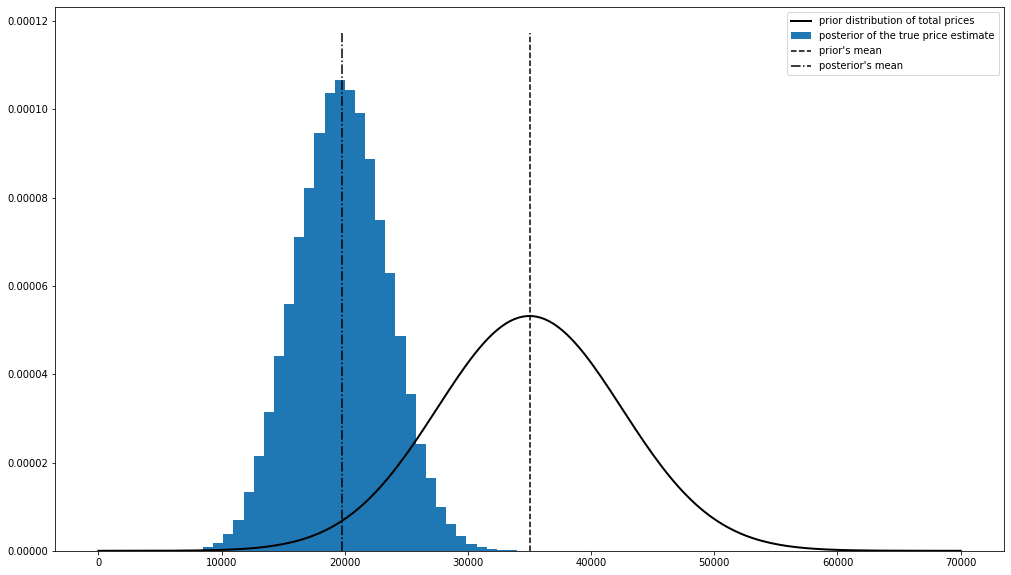

In [52]:
plt.figure(figsize=(17,10))
plt.plot(xs, stats.norm.pdf(xs, muTruePricePrior, sigmaTruePricePrior), label='prior distribution of total prices', color='k', lw=2)
_hist=plt.hist(price_trace, bins=35, density=True, label='posterior of the true price estimate')
plt.vlines(muTruePricePrior, 0, 1.1*np.max(_hist[0]), label = "prior's mean", linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), label = "posterior's mean", linestyles="-.")
plt.legend();

* A frequentist would bid \$35000 (the prior's mean)
* A naive Bayesian would bid ~$20000 (the posterior's mean)
* Or we could use a loss function to incorporate information about eventual outcomes...
  * If our guess is under the true price by less than \$250 then we win our prizes **and the opponent's prizes**, giving us a negative loss which we model as 2x the value of our prizes
  * If our guess is over the true price then we lose. We can use a `risk` parameter to quantify how bad we feel about this - a lower value means we're more comfortable with taking the risk!